In [9]:
import torch
import torch.nn as nn

# Disable scientific notation
torch.set_printoptions(sci_mode=False)

In [5]:
from gpt_model import MultiHeadAttention, LayerNorm, GELU, FeedForward, TransformerBlock, GPTModel
from gpt_model_generate import generate_text_simple, generate
from gpt_model_data_loader import GPTDatasetV1, create_dataloader_v1
from gpt_model_loss import calc_loss_batch, calc_loss_loader
from gpt_model_utility import text_to_token_ids, token_ids_to_text

## Decoding Strategies to Control Randomness

### Decoding Strategy 1: Temperature Scaling

In [10]:
vocab = {
    "closer": 0,
    "every": 1,
    "effort": 2,
    "forward": 3,
    "inches": 4,
    "moves": 5,
    "pizza": 6,
    "toward": 7,
    "you": 8,
    
}

inverse_vocab = {v: k for k, v in vocab.items()}

In [11]:
next_token_logits = torch.tensor(
    [4.51, 0.89, -1.9, 6.75, 1.63, -1.62, -1.89, 6.28, 1.79]
)

In [12]:
probas = torch.softmax(next_token_logits, dim=-1)
print(probas)
next_token_id = torch.argmax(probas).item()
print(next_token_id)
print(inverse_vocab[next_token_id])

tensor([    0.0609,     0.0016,     0.0001,     0.5721,     0.0034,     0.0001,
            0.0001,     0.3576,     0.0040])
3
forward


In [13]:
torch.manual_seed(123)
next_token_id = torch.multinomial(probas, num_samples=1).item()
print(inverse_vocab[next_token_id])

toward


In [14]:
def print_sampled_tokens(probas):
    torch.manual_seed(123)
    sample = [torch.multinomial(probas, num_samples=1).item() for i in range(1_000)]
    sample_ids = torch.bincount(torch.tensor(sample))
    for i, freq in enumerate(sample_ids):
        print(f"{freq} x {inverse_vocab[i]}")

print_sampled_tokens(probas)

71 x closer
2 x every
0 x effort
544 x forward
2 x inches
1 x moves
0 x pizza
376 x toward
4 x you


In [15]:
def softmax_with_temperature(logits, temperature):
    scaled_logits = logits / temperature
    return torch.softmax(scaled_logits, dim=0)

# Temperature values
temperature = [1, 0.1, 5] # Original, higher confidence, lower confidence

# Calculate scaled probabilities
scaled_probas = [softmax_with_temperature(next_token_logits, T) for T in temperature]

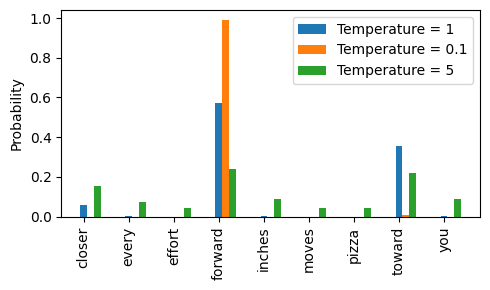

In [17]:
# Plotting
import matplotlib.pyplot as plt

x = torch.arange(len(vocab))
bar_width = 0.15

fig, ax = plt.subplots(figsize=(5,3))
for i, T in enumerate(temperature):
    rects = ax.bar(x+i*bar_width, scaled_probas[i], bar_width, label=f'Temperature = {T}')

ax.set_ylabel('Probability')
ax.set_xticks(x)
ax.set_xticklabels(vocab.keys(), rotation=90)
ax.legend()

plt.tight_layout()
plt.show()

In [18]:
# Probabilities when temperature is 0.1 -- Low randomness/creativity
next_token_logits_2 = next_token_logits / 0.1
probas_2 = torch.softmax(next_token_logits_2, dim=-1)
print(probas_2)

tensor([    0.0000,     0.0000,     0.0000,     0.9910,     0.0000,     0.0000,
            0.0000,     0.0090,     0.0000])


In [19]:
# Probabilities when temperature is 5 -- High randomness/creativity
next_token_logits_3 = next_token_logits / 5
probas_3 = torch.softmax(next_token_logits_3, dim=-1)
print(probas_3)

tensor([0.1546, 0.0750, 0.0429, 0.2421, 0.0869, 0.0454, 0.0430, 0.2203, 0.0898])


### Decoding Strategy 2: Top-k Sampling

In [20]:
next_token_logits = torch.tensor(
    [4.51, 0.89, -1.9, 6.75, 1.63, -1.62, -1.89, 6.28, 1.79]
)

In [21]:
top_k = 3
top_logits, top_pos = torch.topk(next_token_logits, top_k)
print("Top logits:", top_logits)
print("Top Positions:", top_pos)

Top logits: tensor([6.7500, 6.2800, 4.5100])
Top Positions: tensor([3, 7, 0])


In [22]:
new_logits = torch.where(condition=next_token_logits < top_logits[-1],
                        input=torch.tensor(float("-inf")),
                        other=next_token_logits)

print(new_logits)

tensor([4.5100,   -inf,   -inf, 6.7500,   -inf,   -inf,   -inf, 6.2800,   -inf])


In [23]:
topk_probas = torch.softmax(new_logits, dim=0)
topk_probas

tensor([0.0615, 0.0000, 0.0000, 0.5775, 0.0000, 0.0000, 0.0000, 0.3610, 0.0000])